## 3M Data Science Summer Internship 2023: Take-Home Assessment
##### Name: Guilherme de Sousa, PhD Candidate, University of Maryland
##### Contact: gdesousa@umd.edu, https://guidesousa.com

### Summary of results:
1) The business model is very seasonal with large cash flow during summer and winter months.
2) Profit for river tubing is negatively correlated with cloud & rainy weather. Snow tubing is positively correlated with cloud & rainy weather. Both rentals are positively correlated with temperature, too cold is not good for snow tubing. Population and elevation does not have large impacts on the profit.
3) Using a Linear Regression Model we got and score of R^2 ~ %.
4) The most promising new location is Loc XX with a potential revenue of $XXXXX year-to-date in 2022.
5)

### Assumptions & limitations:
- I considered the snow tubing service to happen when temperature < 32F & river tubing when temperature > 32F.
- I counted snowing as precipitation.
- Simplistic method for removing outliers.
- I focused on total profit by suming over all transactions for each day.

### Future work:
- Apply more sophisticated methods for clustering to handle outliers.
- A careful study on the average number of customers for each location could help the company to expand the renting options and services.

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

In [2]:
# Auxiliary functions
def normalize(df, cols=None, norm='mean'):
    result = df.copy()
    if not cols:
        cols = df.columns
    for c in cols:
        if norm == 'mean':
            mea_value = df[c].mean()
            std_value = df[c].std()
            result[c] = (df[c] - mea_value) / std_value
        if norm == 'minmax':
            min_value = df[c].min()
            max_value = df[c].max()
            result[c] = (df[c] - min_value) / (max_value - min_value)
    return result

Text

In [62]:
from os import listdir, getcwd

##############
# Load files #
##############
# PATH
PATH = getcwd() + '/data/'
files = listdir(PATH)

# Location, Holiday and Weather dataframes
df_location = pd.read_csv(PATH+'location_data.csv')
df_holiday = pd.read_csv(PATH+'holiday_data.csv')
df_weather = pd.read_csv(PATH+'weather_data.csv').astype({'date':'datetime64[ns]'})
df_weather['rent'] = df_weather['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')
df_weather['dayofyear'] = df_weather['date'].dt.dayofyear
df_weather['weekofyear'] = df_weather['date'].dt.isocalendar().week
df_weather['month'] = df_weather['date'].dt.month
df_weather['year'] = df_weather['date'].dt.year
df_weather['season'] = df_weather['weekofyear'].apply(lambda x: 0 if ((x > 8) & (x < 22)) or ((x > 36) & (x < 48)) else 1)

# Transactions dataframe
df_transaction = []
for file in files:
    if ('system1' in file):
        df_transaction.append(pd.read_csv(PATH+file, index_col=None, header=0))
    if ('system2' in file):
        df_transaction.append(pd.read_csv(PATH+file, index_col=None, header=0, sep='\t'))
    if ('system3' in file):
        with open(PATH + file) as f:
            data = json.loads(f.read())
            df_transaction.append(pd.json_normalize(data))
df_transaction = pd.concat(df_transaction)
# Remove $ symbol in System 1
df_transaction['profit'] = df_transaction['profit'].apply(lambda x: str(x).split('$')[1] if '$' in str(x) else x)
# Fix negative values of System 2 that writes '0-x' for negative values
df_transaction['profit'] = df_transaction['profit'].apply(lambda x: '-'+str(x).split('-')[1] if '-' in str(x) else x)
# Change column datatypes for a standard format
df_transaction = df_transaction.astype({'location_id':int, 'date':'datetime64[ns]', 'transaction_id':int, 'profit':float})

# Dataframe for daily profit + location information
# Map 'cloudy' and 'precipitation' boolean into 0/1
# DropNA() for use in the modelling
df_profit = df_transaction.groupby([df_transaction['location_id'],df_transaction['date']])[['profit']].agg('sum')
df_profit = pd.merge(df_profit, df_weather, how='left', left_on=['location_id','date'], right_on=['location_id','date'])
df_profit = pd.merge(df_profit, df_location, how='left', left_on=['location_id'], right_on=['location_id'])
df_profit['cloudy'] = df_profit['cloudy'].replace({True: 1, False: 0})
df_profit['precipitation'] = df_profit['precipitation'].replace({True: 1, False: 0})
df_profit = df_profit.dropna()
df_profit = df_profit[df_profit['weekofyear'] != 53] # remove the last week because it contains less than 7 days
#df_profit_norm = normalize(df_profit, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

# Normalize dataframes & groupby time window
df_profit_norm_daily = df_profit.copy()
#df_profit_norm_daily = df_profit_norm_daily[~df_profit_norm_daily['year'].isin([2020])]
df_profit_norm_daily = df_profit_norm_daily.dropna()
df_profit_norm_daily = df_profit_norm_daily.groupby([df_profit_norm_daily['date'].dt.dayofyear, df_profit_norm_daily['location_id']], as_index=False).\
    agg({'profit':'sum','dayofyear':'mean','temperature':'mean','pressure':'mean','cloudy':'mean',
    'precipitation':'mean','humidity':'mean','population':'mean','elevation':'mean','season':'mean'})
df_profit_norm_daily['rent'] = df_profit_norm_daily['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')
df_profit_norm_daily = normalize(df_profit_norm_daily, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

df_profit_norm_weekly = df_profit.copy()
#df_profit_norm_weekly = df_profit_norm_weekly[~df_profit_norm_weekly['year'].isin([2020])]
df_profit_norm_weekly = df_profit_norm_weekly.dropna()
df_profit_norm_weekly = df_profit_norm_weekly.groupby([df_profit_norm_weekly['date'].dt.isocalendar().week, df_profit_norm_weekly['location_id']], as_index=False).\
    agg({'profit':'sum','weekofyear':'mean','temperature':'mean','pressure':'mean','cloudy':'mean',
    'precipitation':'mean','humidity':'mean','population':'mean','elevation':'mean','season':'mean'})
df_profit_norm_weekly['rent'] = df_profit_norm_weekly['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')
df_profit_norm_weekly = normalize(df_profit_norm_weekly, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

df_profit_norm_monthly = df_profit.copy()
#df_profit_norm_monthly = df_profit_norm_monthly[~df_profit_norm_monthly['year'].isin([2020])]
df_profit_norm_monthly = df_profit_norm_monthly.dropna()
df_profit_norm_monthly = df_profit_norm_monthly.groupby([df_profit_norm_monthly['date'].dt.month, df_profit_norm_monthly['location_id']], as_index=False).\
    agg({'profit':'sum','month':'mean','temperature':'mean','pressure':'mean','cloudy':'mean',
    'precipitation':'mean','humidity':'mean','population':'mean','elevation':'mean','season':'mean'})
df_profit_norm_monthly['rent'] = df_profit_norm_monthly['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')
df_profit_norm_monthly = normalize(df_profit_norm_monthly, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

# Sample values
df_profit.sample(10)

# Basic statistics
#df_profit.describe()

,location_id,date,profit,temperature,pressure,humidity,cloudy,precipitation,rent,dayofyear,weekofyear,month,year,season,population,elevation
7519,10,2022-02-08,135.57,12.92,1039.072770,0.76,0.0,0.0,snow,39.0,6,2.0,2022.0,1.0,425336,266
605,1,2022-01-12,168.70,7.34,988.673709,0.00,1.0,1.0,snow,12.0,2,1.0,2022.0,1.0,18428,375
6299,9,2019-09-03,422.97,68.36,983.767606,0.97,1.0,0.0,river,246.0,36,9.0,2019.0,1.0,13641,350
251,1,2020-02-29,225.74,27.86,981.091549,0.14,1.0,0.0,snow,60.0,9,2.0,2020.0,0.0,18428,375
6319,9,2019-12-14,510.24,15.98,1016.326291,0.18,1.0,1.0,snow,348.0,50,12.0,2019.0,1.0,13641,350
6963,10,2019-06-05,178.02,74.66,1000.492958,0.85,1.0,1.0,river,156.0,23,6.0,2019.0,1.0,425336,266
831,2,2019-05-31,117.76,57.20,999.823944,0.96,1.0,1.0,river,151.0,22,5.0,2019.0,1.0,32926,274
3505,5,2021-06-05,131.57,49.82,967.488263,1.00,1.0,1.0,river,156.0,22,6.0,2021.0,1.0,12686,386
2574,4,2020-07-02,288.17,72.86,1010.974178,0.94,0.0,0.0,river,184.0,27,7.0,2020.0,1.0,14255,360
3251,5,2020-01-23,203.65,13.10,1022.347418,0.00,0.0,0.0,snow,23.0,4,1.0,2020.0,1.0,12686,386


Text

<AxesSubplot:xlabel='year', ylabel='profit'>

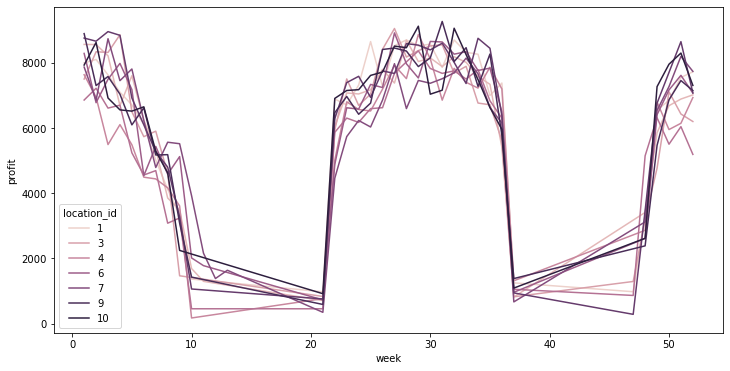

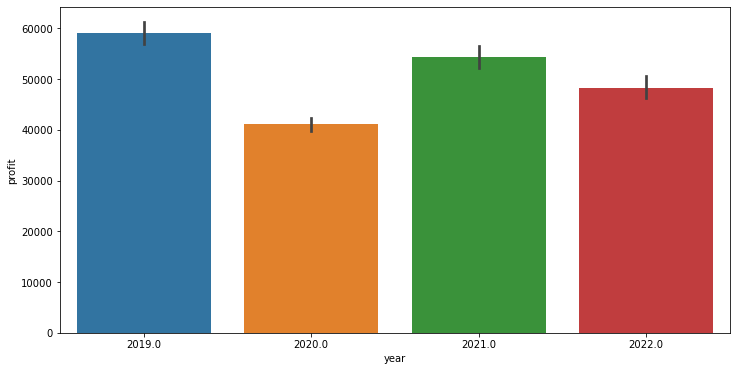

In [17]:
# Rental Profit Variation
# We have cyclic pattern - Large profits during winter with snow tubing and during summer with river tubing
# This result indicates we should include the time dependence into account for modelling the profit for each location
df = df_profit
plt.figure(figsize=(12,6))
sns.lineplot(data=df.groupby([df['date'].dt.isocalendar().week, df['location_id']]).agg({'profit':'sum'}), x='week', y='profit', hue='location_id')

# Yearly dependence of the profits
# Probably because of the disruptions caused by the pandemic we should be carefull to compare year to year
df = df_profit
plt.figure(figsize=(12,6))
sns.barplot(data=df.groupby(['year', 'location_id'], as_index=False).agg({'profit':'sum'}), x='year', y='profit')

Text

Text(0.5, 1.08, 'Monthly distribution')

<Figure size 576x432 with 0 Axes>

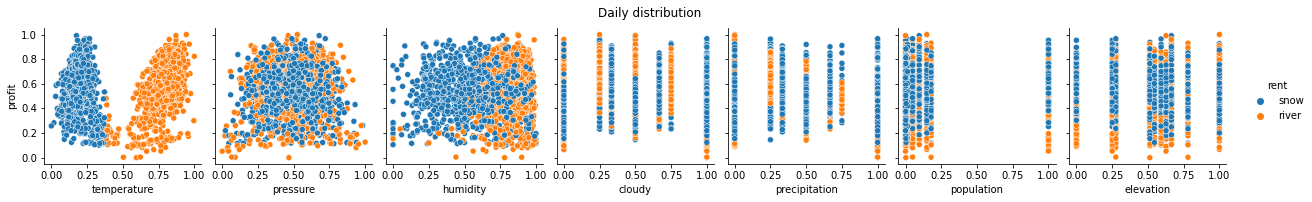

<Figure size 576x432 with 0 Axes>

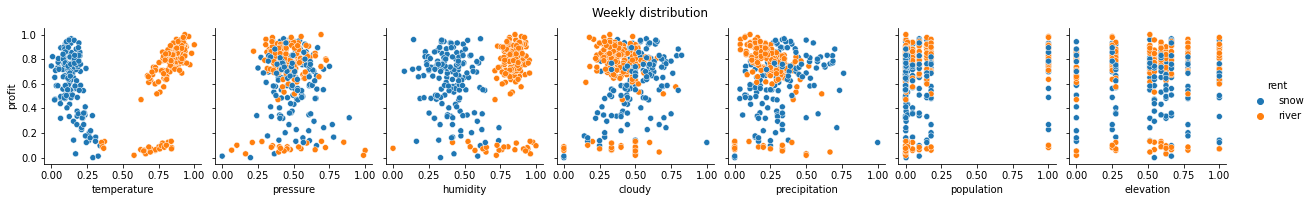

<Figure size 576x432 with 0 Axes>

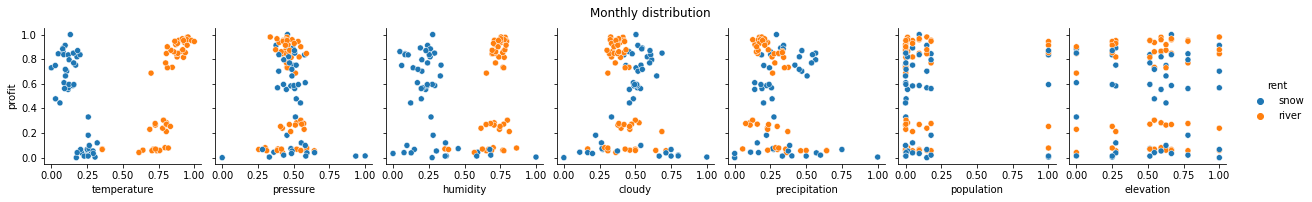

In [18]:
# Here I plotted the datapoints of profit as a function of the other parameters for three different time windows
# Dt = {daily, weekly, monthly}
# Visually, the weekly time frame seems to capture the correlation with less noise
df = df_profit_norm_daily
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='rent', kind='scatter')
s.fig.suptitle('Daily distribution', y=1.08)

df = df_profit_norm_weekly
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='rent', kind='scatter')
s.fig.suptitle('Weekly distribution', y=1.08)

df = df_profit_norm_monthly
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='rent', kind='scatter')
s.fig.suptitle('Monthly distribution', y=1.08)

Now that I identified the optimal time window (weekly) for this analysis we can ask how much the data depends on the season/off-season cycles.

Text(0.5, 1.08, 'Weekly distribution')

<Figure size 576x432 with 0 Axes>

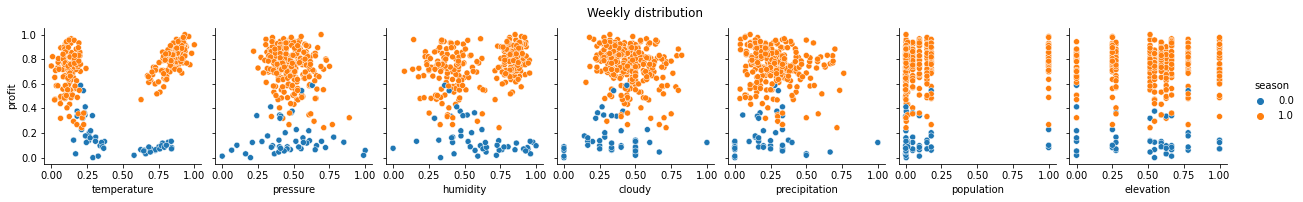

In [19]:
# Season/Off-Season distributions
df = df_profit_norm_weekly
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='season', kind='scatter')
s.fig.suptitle('Weekly distribution', y=1.08)

Text

Text(0.5, 1.0, 'Profit correlation - Weekly window')

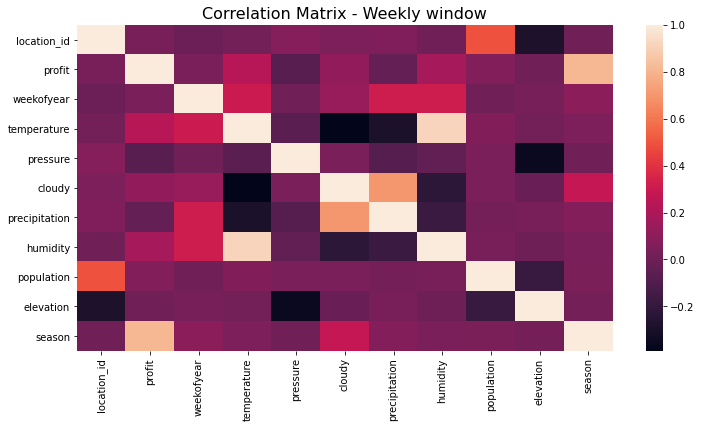

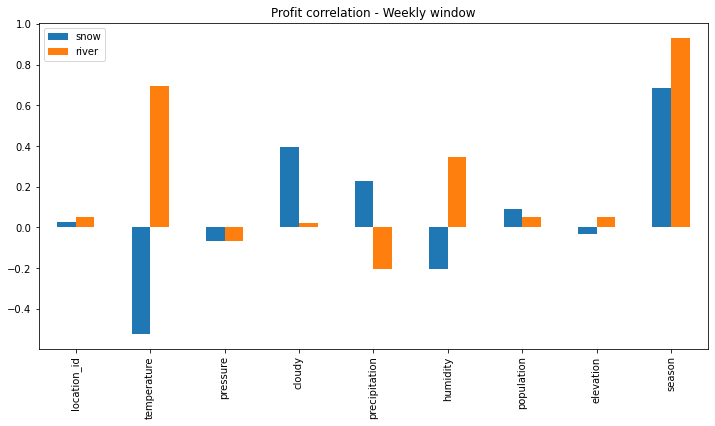

In [41]:
# Correlation Matrix for normalized Dt=daily profit dataframe
fig = plt.figure(figsize=(12, 6))
h = sns.heatmap(df_profit_norm_weekly.corr())
#plt.xticks(range(df_profit_norm.select_dtypes(['number']).shape[1]), df_profit_norm.select_dtypes(['number']).columns, fontsize=14, rotation=45)
#plt.yticks(range(df_profit_norm.select_dtypes(['number']).shape[1]), df_profit_norm.select_dtypes(['number']).columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
h.set_title('Correlation Matrix - Weekly window', fontsize=16)

# Profit correlation to the other variables
df_cor = pd.DataFrame()
for rent in ['snow', 'river']:
    df_cor[rent] = df_profit_norm_weekly[df_profit_norm_weekly['rent']==rent].drop('weekofyear',axis=1).corr()['profit'].drop('profit')
df_cor.plot.bar(figsize=(12, 6))
#df_nor[df_nor['rent']=='river'].corr()['profit'].drop('profit').plot.bar()
plt.title('Profit correlation - Weekly window')

Text

c:\Users\guilh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


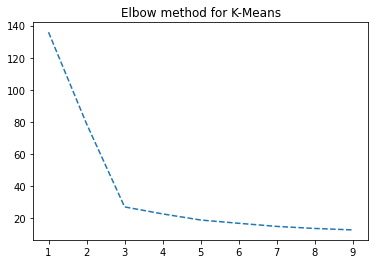

<Figure size 576x432 with 0 Axes>

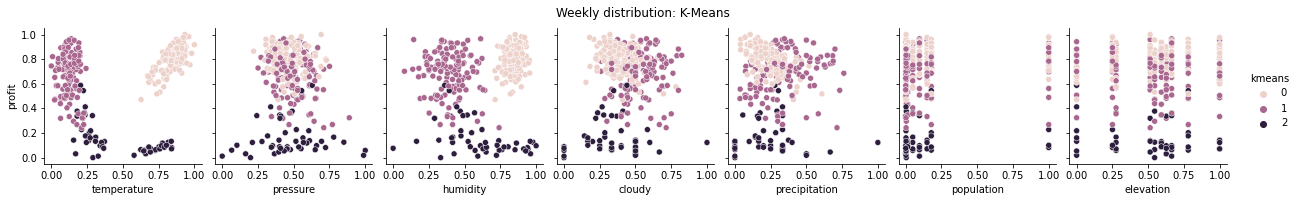

In [63]:
# K-Means clustering to identify commom regimes of business operations
# Elbow method for optimal number of clusters
from sklearn.cluster import KMeans

# Data
df = df_profit_norm_weekly.copy()
#df = df_profit_norm_monthly.copy()
#df = df_profit_norm.drop(['date'],axis=1).copy()

K = range(1,10)
kmeans_score = np.zeros(len(K))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df.drop(['location_id','weekofyear','rent','population', 'elevation', 'pressure'],axis=1))
    kmeans_score[k-1] = kmeanModel.inertia_
s = sns.lineplot(x=K, y=kmeans_score, linestyle='--')
s.set_title('Elbow method for K-Means')

# Choosing K-means with 3 clusters
K = 3
kmeanModel = KMeans(n_clusters=K)
kmeanModel.fit(df.drop(['location_id','weekofyear','rent','pressure','population'],axis=1))
df_profit_norm_weekly['kmeans'] = pd.Series(kmeanModel.labels_)

# Plot dataframe clustered by K-Means
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df_profit_norm_weekly, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='kmeans')
s.fig.suptitle('Weekly distribution: K-Means', y=1.08)

# Add a new K-Means cluster to differentiate snow and river tubing
kmeans_keys = df_profit_norm_weekly.groupby('kmeans').agg({'temperature':'max'}).to_dict()['temperature']
river_cluster = max(kmeans_keys, key=kmeans_keys.get)
snow_cluster = min(kmeans_keys, key=kmeans_keys.get)
keys = [0,1,2]
keys.pop(snow_cluster)
keys.pop(river_cluster)
off_season_cluster = keys[0]
df_profit_norm_weekly['rent'] = df_profit_norm_weekly[['rent','kmeans']].apply(lambda x: x['rent']+'_off' if x['kmeans'] == off_season_cluster else x['rent'], axis=1)

Text

Model snow 0.15747242243648174
Model river 0.7472065381954736
Model snow_off 0.007678789932247465
Model river_off 0.5372494183365907


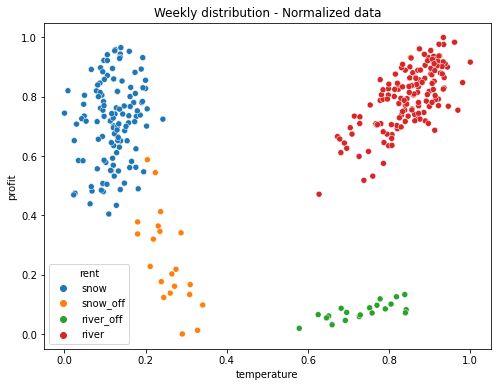

In [82]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Remove outliners
df = df_profit_norm_weekly.copy()
df['rent'] = df[['rent', 'profit', 'temperature']].apply(lambda x: 'outliers' if (x['temperature'] < 0.4) & (x['rent'] == 'river_off') else x['rent'], axis=1)
df['rent'] = df[['rent', 'profit', 'temperature']].apply(lambda x: 'outliers' if (x['profit'] < 0.2) & (x['temperature'] < 0.2) & (x['rent'] == 'snow_off') else x['rent'], axis=1)
df['rent'] = df[['rent', 'profit', 'temperature']].apply(lambda x: 'outliers' if (x['profit'] < 0.4) & (x['rent'] == 'snow') else x['rent'], axis=1)

# Plot dataframe distribution
plt.figure(figsize=(8,6))
s = sns.scatterplot(data=df[df['rent'] != 'outliers'], x='temperature', y='profit', hue='rent')
s.set_title('Weekly distribution - Normalized data')

# Train-Test data
# Season dependent model
# River tubing and Snow tubing
model = {}
for label in ['snow','river','snow_off','river_off']:
    x = df.loc[df['rent']==label,['temperature','cloudy','precipitation']].to_numpy()
    #x = df.loc[df['rent']==rent,['temperature']].to_numpy()
    y = df.loc[df['rent']==label,'profit'].to_numpy()
    y = y.reshape(-1, 1)

    # Linear model training
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

    # Model Fit + Prediction
    model[label] = LinearRegression()
    model[label].fit(xtrain, ytrain)
    ypred = model[label].predict(xtest)
    ypred = ypred.reshape(1,-1)[0]
    print('Model',label,model[label].score(xtest,ytest))

    # Plotting linear regression
    #line_x = np.linspace(x[:,0].min(), x[:,0].max(), 100)
    #line_y = model[label].intercept_[0] + model[label].coef_[0][0]*line_x
    #sns.lineplot(x=line_x, y=line_y, linestyle='-', color='red')
    #sns.lineplot(x=xtest[:,0], y=ypred, linestyle='-', color='red')

# Predict profit for new locations
new_loc = [11,12,13]
df_weather_new_loc = df_weather[df_weather['location_id'].isin(new_loc)]
df_weather_new_loc_weekly = df_weather_new_loc.groupby([df_weather_new_loc['location_id'], df_weather_new_loc['date'].dt.isocalendar().week], as_index=False).agg('mean')
df_weather_new_loc_weekly['rent'] = df_weather_new_loc_weekly['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')

Text

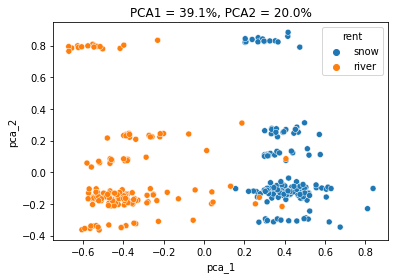

In [67]:
# PCA - Principal Component Analysis
from sklearn.decomposition import PCA

# Number of components
n_components = 5

# PCA Fit
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(df_profit_norm_weekly.drop(['location_id','rent','weekofyear'],axis=1))
df_pca = pd.DataFrame(data=principalComponents, columns=[f'pca_{i}' for i in range(1,n_components+1)])
df_pca = pd.concat([df_pca, df_profit_norm_weekly['rent']], axis=1)

# Plot along the 2 largest PCA components
# The 2 main PCA componentes explain 96% of the data variance
s = sns.scatterplot(data=df_pca, x='pca_1', y='pca_2', hue='rent').\
    set(title=f'PCA1 = {pca.explained_variance_ratio_[0]*100:.1f}%, PCA2 = {pca.explained_variance_ratio_[1]*100:.1f}%')

# PCA componentes in terms of the original variables
print('')

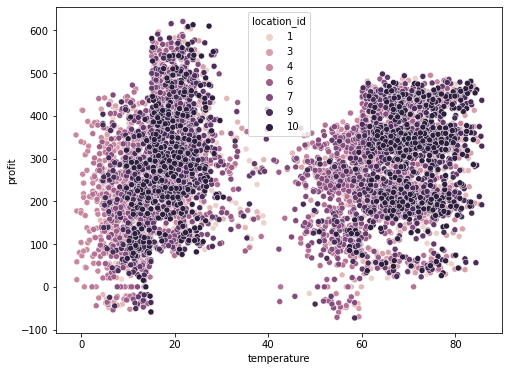

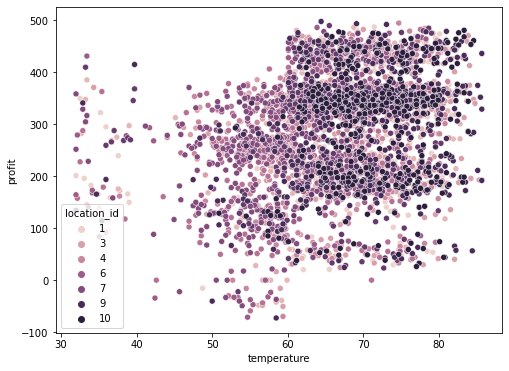

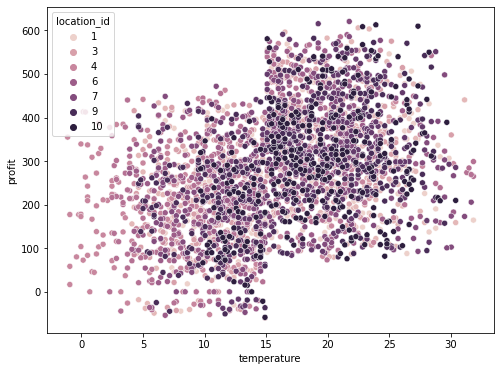

In [180]:
# Total profit for each day for all locations
df = df_profit
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='temperature', y='profit', hue='location_id')

plt.figure(figsize=(8,6))
sns.scatterplot(data=df[df['rent']=='river'], x='temperature', y='profit', hue='location_id')
plt.figure(figsize=(8,6))
sns.scatterplot(data=df[df['rent']=='snow'], x='temperature', y='profit', hue='location_id')

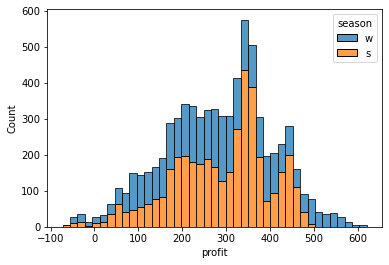

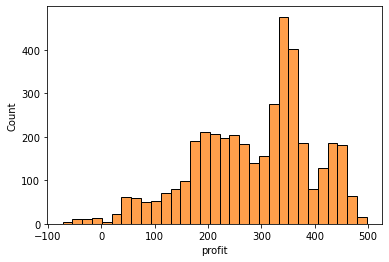

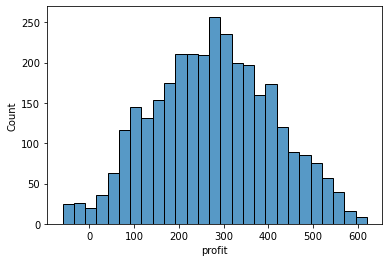

In [35]:
# Total profit for each day for all locations
sns.histplot(data=df_profit, x='profit', hue='rent', multiple='stack')

plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='river'], x='profit', color='C1')
plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='snow'], x='profit')

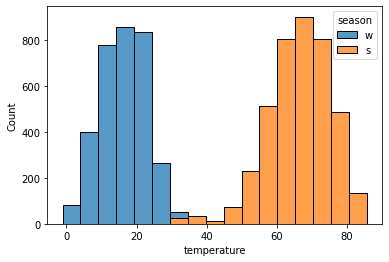

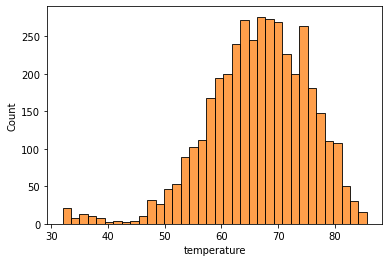

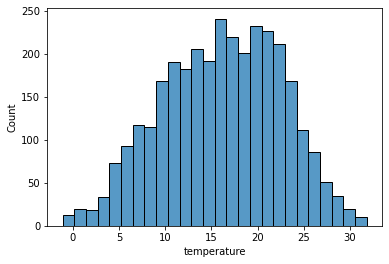

In [34]:
# Total profit for each day for all locations
sns.histplot(data=df_profit, x='temperature', hue='rent', multiple='stack')

plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='river'], x='temperature', color='C1')
plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='snow'], x='temperature')

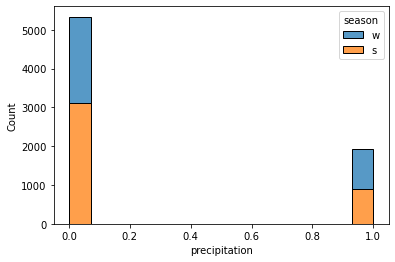

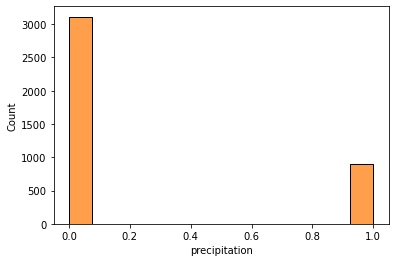

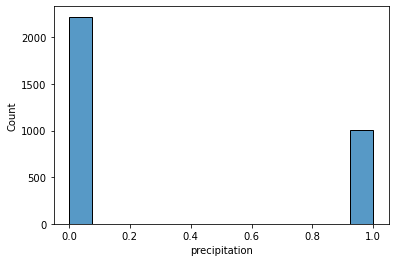

In [36]:
# Total profit for each day for all locations
sns.histplot(data=df_profit, x='precipitation', hue='rent', multiple='stack')

plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='river'], x='precipitation', color='C1')
plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='snow'], x='precipitation')

In [290]:
df_profit_norm_daily

profit  temperature  pressure  humidity  cloudy  \
date location_id                                                      
2    1            0.672462     0.131094  0.555283  0.520000    0.00   
     2            0.738479     0.124052  0.353808  0.435000    0.50   
     3            0.696233     0.197725  0.393735  0.500000    0.25   
     4            0.696970     0.072589  0.316339  0.585000    0.50   
     5            0.736817     0.157819  0.434070  0.426667    0.00   
...                    ...          ...       ...       ...     ...   
366  6            0.469674     0.167931  0.800983  0.360000    1.00   
     7            0.721671     0.239437  0.321867  0.650000    0.00   
     8            0.696036     0.269772  0.909091  0.000000    1.00   
     9            0.674809     0.196100  0.869779  0.860000    1.00   
     10           0.455439     0.109426  0.680590  0.730000    1.00   

                  precipitation  day_of_year  population  elevation season  
date location_id                                                            
2    1                     0.00          0.0    0.013915   0.592476      w  
     2                     0.25          0.0    0.049049   0.275862      w  
     3                     0.25          0.0    0.148920   1.000000      w  
     4                     0.50          0.0    0.003802   0.545455      w  
     5                     0.00          0.0    0.000000   0.626959      w  
...                         ...          ...         ...        ...    ...  
366  6                     1.00          1.0    0.178568   0.780564      w  
     7                     0.00          1.0    0.001730   0.000000      w  
     8                     0.00          1.0    0.095720   0.664577      w  
     9                     0.00          1.0    0.002314   0.514107      w  
     10                    0.00          1.0    1.000000   0.250784      w  

[2152 rows x 10 columns]

In [288]:
# Total profit for each day for all locations
col = df_profit_norm_daily['location_id'].map({i:f'C{i}' for i in range(11)})
df_profit_norm_daily.plot.scatter(x='pressure', y='profit', c=col, figsize=(8,6))

col_s = df_profit_norm_daily[df_profit_norm_daily['rent']=='river']['location_id'].map({i:f'C{i}' for i in range(11)})
col_w = df_profit_norm_daily[df_profit_norm_daily['rent']=='snow']['location_id'].map({i:f'C{i}' for i in range(11)})
df_profit_norm_daily[df_profit_norm_daily['rent']=='river'].plot.scatter(x='pressure', y='profit', c=col_s, figsize=(8,6), title='summer')
df_profit_norm_daily[df_profit_norm_daily['rent']=='snow'].plot.scatter(x='pressure', y='profit', c=col_w, figsize=(8,6), title='winter')

KeyError: 'location_id'

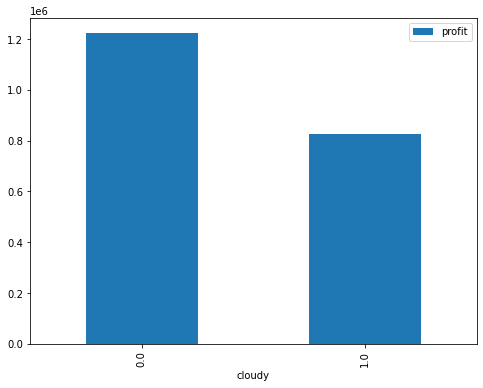

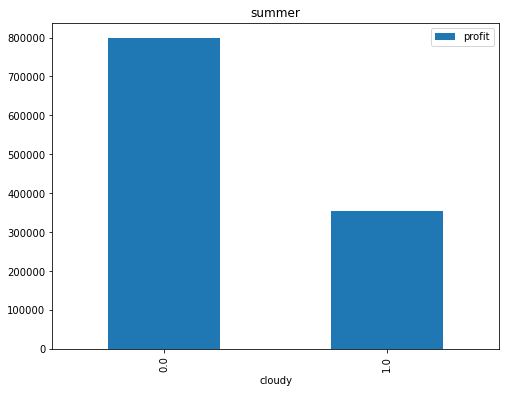

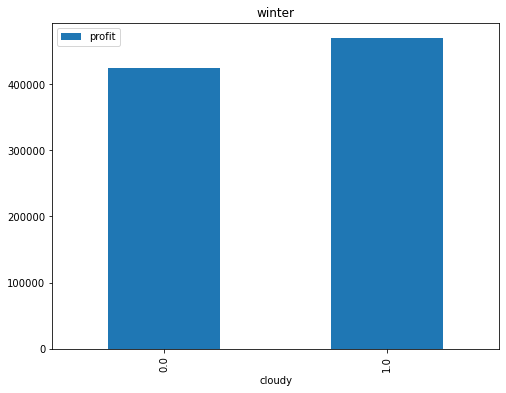

In [46]:
# Total profit for each day for all locations
col = df_profit['location_id'].map({i:f'C{i}' for i in range(11)})
df_profit.groupby('cloudy').agg({'profit':'sum'}).plot.bar(figsize=(8,6))

col_s = df_profit[df_profit['rent']=='river']['location_id'].map({i:f'C{i}' for i in range(11)})
col_w = df_profit[df_profit['rent']=='snow']['location_id'].map({i:f'C{i}' for i in range(11)})
df_profit[df_profit['rent']=='river'].groupby('cloudy').agg({'profit':'sum'}).plot.bar(figsize=(8,6), title='summer')
df_profit[df_profit['rent']=='snow'].groupby('cloudy').agg({'profit':'sum'}).plot.bar(figsize=(8,6), title='winter')

In [65]:
df_profit.describe()

,location_id,profit,temperature,pressure,humidity,cloudy,precipitation,population,elevation
count,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000
mean,5.493657,282.255153,43.993356,1001.474523,0.691995,0.438776,0.264341,73363.085080,352.880033
std,2.863817,120.936549,26.236902,25.112211,0.305839,0.496272,0.441012,118531.950909,87.194837
min,1.000000,-72.750000,-1.120000,955.000000,0.000000,0.000000,0.000000,12686.000000,186.000000
25%,3.000000,198.190000,17.420000,979.920775,0.550000,0.000000,0.000000,13641.000000,274.000000
50%,6.000000,292.905000,55.220000,1001.384977,0.800000,0.000000,0.000000,18428.000000,375.000000
75%,8.000000,362.292500,68.000000,1023.016432,0.930000,1.000000,1.000000,74138.000000,398.000000
max,10.000000,620.410000,85.640000,1049.776995,1.000000,1.000000,1.000000,425336.000000,505.000000
